# **CT SCAN IMAGE CLASSIFICATION USING RESNET-50**

---

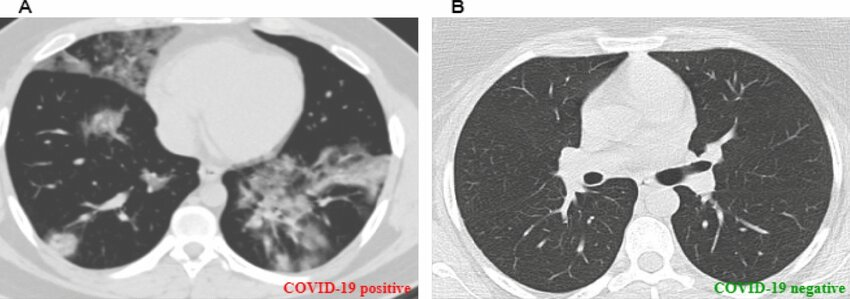

## Step 01 : ***Data Preparation***

---



### The first step is to prepare the CT scan images for training and testing the deep learning model. This involves preprocessing the images, such as resizing, normalizing, and augmenting the data.

In [ ]:
# code used to mount the drive to google colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import necessary libraries

# importing basic libraries for data preparation

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2

# importing libraries for model building and evaluation.

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Input

In [ ]:
# Create DataFrame defining three columns for the file path, class label, and class name.
# This DataFrame will be used later for loading the CT scan images.

disease_types = ['COVID', 'non-COVID']

train_directory = '/content/drive/MyDrive/Capstone_project/CT_Scan'

train_data_info = []

for class_index, class_name in enumerate(disease_types):
    for file_name in os.listdir(os.path.join(train_directory, class_name)):
        train_data_info.append([os.path.join(train_directory, class_name, file_name), class_index, class_name])

train_data = pd.DataFrame(train_data_info, columns = ['File Path', 'Class Label','Class Name'])


In [ ]:
# the purpose of the below code  is to shuffle the data and reset the indices.

# Set a seed for reproducibility
Seed = 40

# Shuffle the data using the seed and reset the indices
train = train_data.sample(frac = 1, replace=False, random_state = Seed)
train = train.reset_index(drop = True)

# Plot a frequency histogram to show the distribution of classes
sns.countplot(x = "Class Label", data = train)
for i in range(len(train['Class Label'].value_counts().values)):
    plt.text(x=i, y=train['Class Label'].value_counts().values[i]+5, s=train['Class Label'].value_counts().values[i], ha='center')
plt.title("Frequency Histogram (0: COVID, 1:Non-COVID)")


In [ ]:
# function to display the image of datasets.

def plot_defects(defect_types, rows, cols):
    # Create a figure and subplots with specified number of rows and columns
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    
    # Get all file names for the given defect type
    defect_files = train['File Path'][train['Class Name'] == defect_types].values
    
    # Counter variable to keep track of the number of images displayed
    n = 0
    
    # Set the title of the figure with the given defect type
    fig.suptitle(defect_types, fontsize = 22, color = "Black")
    
    # Loop through the specified number of rows and columns
    for i in range(rows):
        for j in range(cols):
            # Get the image path for the current file name
            image_path = os.path.join(train_directory, defect_files[n])
            
            # Remove the x-axis and y-axis ticks
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            
            # Display the image in the current subplot
            
            ax[i, j].imshow(cv2.imread(image_path))
            
            # Increment the counter variable
            n += 1


# Call the function to display images of COVID cases
plot_defects('COVID', 5, 5)

# Call the function to display images of non-COVID cases
plot_defects('non-COVID', 5, 5)



In [ ]:
# The following code contains two functions to read an image and resize it using the OpenCV library.

IMAGE_SIZE = 224

# Function to load the image
def read_image(filepath):
    return cv2.imread(os.path.join(train_directory, filepath))

# Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [ ]:
# the following code reshape the image and normalized the pixel
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File Path'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['Class Label'].values, num_classes = 2)

print(Y_train)

In [ ]:
# Image Augmentation

datagen = ImageDataGenerator(rotation_range = 360, 
                        width_shift_range = 0.2,  
                        height_shift_range = 0.2,  
                        zoom_range = 0.2,          
                        horizontal_flip = True,
                        vertical_flip = True)       


## Step 02 : ***Splitting the data***

---

### In this step data is split into two parts. one in training set other in test set. Training set is used to train the model where as test set is used to test the model efficiency. generally we provide more data for training than testing so we devide our dataset in the ratio of 80:20 ,where 80% data is for training and 20% data is for testing.

In [ ]:
# Split the data set into traing and testing in 80:20 ratio.

X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2, 
                                                  random_state = Seed)

print(f'X_train:', X_train.shape)
print(f'X_val:', X_val.shape)
print(f'Y_train:', Y_train.shape)
print(f'Y_val:', Y_val.shape)

## Step 03 : ***Bulding and Visualizing the model using ResNet-50***

---

### In this step we will build the model using ResNet-50, then making use of training set train the model and using test set evaluate the model and plot some visualization.

In [ ]:
# Architectural function for Resnet50 with added comments
def build_resnet50(IMAGE_SIZE, channels):

    # Loading ResNet50 pre-trained model from ImageNet database
    resnet50 = ResNet50(weights = 'imagenet', include_top = False)

    # Input layer with specified shape (IMAGE_SIZE, IMAGE_SIZE, channels)
    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    
    # Convolutional layer with 3 filters of size 3x3 and padding set to 'same'
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    
    # Pass the output of the Convolutional layer through the ResNet50 model
    x = resnet50(x)
    
    # Global Average Pooling layer to reduce the spatial dimensions of the output
    x = GlobalAveragePooling2D()(x)
    
    # Batch Normalization layer to normalize the activations of the previous layer
    x = BatchNormalization()(x)
    
    # Dense layer with 64 neurons and ReLU activation function
    x = Dense(64, activation = 'relu')(x)
    
    # Batch Normalization layer to normalize the activations of the previous layer
    x = BatchNormalization()(x)
    
    # Output layer with 2 neurons and softmax activation function
    output = Dense(2, activation = 'softmax')(x)
 
    # Create a Model object by specifying the input and output
    model = Model(input, output)
    
    # Adam optimization algorithm to minimize the loss function
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    

    # Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    
    # Print the summary of the model architecture
    model.summary()
    
    # Return the compiled model
    return model


In [ ]:
# Code to train and compile the ResNet50 model
channels = 3

# Call the build_resnet50 function to get the ResNet50 model
model = build_resnet50(IMAGE_SIZE, channels)

# ReduceLROnPlateau is a Keras callback that reduces the learning rate when the validation accuracy plateaus
annealer = ReduceLROnPlateau(monitor = 'val_accuracy', 
                             factor = 0.70, 
                             patience = 5,  
                             verbose = 1,   
                             min_lr = 1e-4   
                            )

# ModelCheckpoint is a Keras callback to save the model after each epoch
checkpoint = ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)  

# Fit the data generator to the training data
datagen.fit(X_train)

# Plot the model architecture to a file
plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)


In [ ]:
# Define the batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 50

# Fit the model to the training data using data augmentation and validation data
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
                 # Calculate the number of steps per epoch based on batch size and training data size
                 steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                 # Specify the number of epochs
                 epochs = EPOCHS,
                 # Display progress in verbose mode
                 verbose = 1,
                 # Use specified callbacks during training
                 callbacks = [annealer, checkpoint],
                 # Use validation data to evaluate model performance
                 validation_data = (X_val, Y_val))


In [ ]:
# Predict the class labels for the validation data
Y_pred = model.predict(X_val)

# Convert the predicted class probabilities to class labels
Y_pred = np.argmax(Y_pred, axis = 1)

# Convert the true class probabilities to class labels
Y_true = np.argmax(Y_val, axis = 1)

# Calculate the confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)

# Calculate the number of true positives, false negatives, true negatives, and false positives
TP = cm[1][1]
FN = cm[1][0]
TN = cm[0][0]
FP = cm[0][1]

# Calculate the true positive rate (sensitivity, recall)
print(f"True Positive Rate: {TP / (TP + FN)}")

# Calculate the true negative rate (specificity)
print(f"True Negative Rate: {TN / (TN + FP)}\n")

# Evaluate the model on the validation data
final_loss, final_accuracy = model.evaluate(X_val, Y_val)

# Display the final loss and accuracy of the model
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")


In [ ]:
# Plotting Accuracy and Loss

# Plotting the accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

# Plotting the loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()


In [ ]:
# import the required module
from keras.preprocessing import image

# load an image and resize it to the specified target size
img = image.load_img('/content/drive/MyDrive/CT scan/COVID/Covid (1007).png', grayscale=False, target_size=(224, 224))

# load the same image again for display purposes and resize it to a different size
show_img = image.load_img('/content/drive/MyDrive/CT scan/COVID/Covid (1007).png', grayscale=False, target_size=(200, 200))

# create a list of class labels
disease_class = ['Covid-19', 'Non Covid-19']

# convert the image to a NumPy array and add an extra dimension to represent the batch size
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# normalize the pixel values between 0 and 1
x /= 255

# use the trained model to make a prediction on the input image
custom = model.predict(x)

# print the predicted probabilities for each class
print(custom[0])

# display the image
plt.imshow(show_img)
plt.show()

# get the predicted class label by finding the index of the maximum probability
a = custom[0]
ind = np.argmax(a)

# print the predicted class label
print('Prediction:', disease_class[ind])
